In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
#device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

def set_seed(seed):
    torch.manual_seed(seed)

def get_hyperparameters():
    return {
        "learning_rate": 5e-5,
        "batch_size": 64,
        "image_size": 64,
        "image_channels": 3,
        "z_dimension": 128,
        "epochs": 50,
        "discriminator_features": 64,
        "generator_features": 64,
        "discriminator_iterations": 5,
        "weight": 0.01
    }

def get_transforms(image_channels):
    return transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(image_channels)], [0.5 for _ in range(image_channels)]
        ),
    ])

def get_cifar10_dataset(transforms):
    return torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        transform=transforms,
                                        download=True)

def get_data_loader(dataset, batch_size):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


set_seed(1)
hyperparams = get_hyperparameters()

learning_rate = hyperparams["learning_rate"]
batch_size = hyperparams["batch_size"]
image_size = hyperparams["image_size"]
image_channels = hyperparams["image_channels"]
epochs = hyperparams["epochs"]
transforms = get_transforms(image_channels)
data_train = get_cifar10_dataset(transforms)
train_loader = get_data_loader(data_train, batch_size)


Files already downloaded and verified


In [14]:
# New
class Discriminator(nn.Module):
    def __init__(self, img_channels, disc_features):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            # input: N x img_channels x 64 x 64
            nn.Conv2d(
                img_channels, disc_features, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _discriminator_block(in_channels, out_channels, kernel_size, stride, padding)
            self._discriminator_block(disc_features, disc_features * 2, 4, 2, 1),
            nn.Dropout(0.3),
            self._discriminator_block(disc_features * 2, disc_features * 4, 4, 2, 1),
            nn.Dropout(0.3),
            self._discriminator_block(disc_features * 4, disc_features * 8, 4, 2, 1),
            nn.Dropout(0.3),
            # After all _discriminator_block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(disc_features * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _discriminator_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.discriminator(x)


class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels, gen_features):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # Input: N x noise_channels x 1 x 1
            self._generator_block(noise_channels, gen_features * 16, 4, 1, 0),  # img: 4x4
            nn.Dropout(0.3),
            self._generator_block(gen_features * 16, gen_features * 8, 4, 2, 1),  # img: 8x8
            nn.Dropout(0.3),
            self._generator_block(gen_features * 8, gen_features * 4, 4, 2, 1),  # img: 16x16
            nn.Dropout(0.3),
            self._generator_block(gen_features * 4, gen_features * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                gen_features * 2, img_channels, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x img_channels x 64 x 64
            nn.Tanh(),
        )

    def _generator_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.generator(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [29]:
generator = Generator(z_dimension, image_channels, generator_features).to(device)
discriminator = Discriminator(image_channels, discriminator_features).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

# Initialize optimizer
optimizer_gen = optim.RMSprop(generator.parameters(), lr=learning_rate)
optimizer_disc = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

# For tensorboard plotting
fixed_noise = torch.randn(10, z_dimension, 1, 1).to(device)
step = 0
loss_generator_list = []
loss_discriminator_list = []
generator.train()
discriminator.train()
generated_img_list = []
real_img_list = []

for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Discriminator: max E[discriminator(real)] - E[discriminator(fake)]
        for _ in range(discriminator_iterations):
            noise = torch.randn(cur_batch_size, z_dimension, 1, 1).to(device)
            fake = generator(noise)
            disc_real = discriminator(data).reshape(-1)
            disc_fake = discriminator(fake).reshape(-1)
            loss_disc = -(torch.mean(disc_real) - torch.mean(disc_fake))
            discriminator.zero_grad()

            loss_disc.backward(retain_graph=True)
            optimizer_disc.step()

            # Clip discriminator weights between -0.01, 0.01
            for p in discriminator.parameters():
                p.data.clamp_(-weight, weight)

        # Train Generator: max E[discriminator(gen_fake)] <-> min -E[discriminator(gen_fake)]
        gen_fake = discriminator(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)

        generator.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        loss_discriminator_list.append(loss_disc.detach().cpu())
        loss_generator_list.append(loss_gen.detach().cpu())

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            generator.eval()
            discriminator.eval()
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                generated_imgs = generator(fixed_noise).detach().cpu()
                real_imgs = data.detach().cpu()
                generated_img_list.append(torchvision.utils.make_grid(generated_imgs, padding=2, normalize=True))
                real_img_list.append(torchvision.utils.make_grid(real_imgs, padding=2, normalize=True))

            step += 1
            generator.train()
            discriminator.train()


Epoch [0/50] Batch 100/782                   Loss D: -1.4084, loss G: 0.7028
Epoch [0/50] Batch 200/782                   Loss D: -1.5065, loss G: 0.7460
Epoch [0/50] Batch 300/782                   Loss D: -1.5058, loss G: 0.7432
Epoch [0/50] Batch 400/782                   Loss D: -1.5254, loss G: 0.7495
Epoch [0/50] Batch 500/782                   Loss D: -1.4759, loss G: 0.7300
Epoch [0/50] Batch 600/782                   Loss D: -1.4913, loss G: 0.7312
Epoch [0/50] Batch 700/782                   Loss D: -1.4585, loss G: 0.7263
Epoch [1/50] Batch 100/782                   Loss D: -1.2982, loss G: 0.6370
Epoch [1/50] Batch 200/782                   Loss D: -1.2793, loss G: 0.6480
Epoch [1/50] Batch 300/782                   Loss D: -1.2303, loss G: 0.6578
Epoch [1/50] Batch 400/782                   Loss D: -1.2144, loss G: 0.5660
Epoch [1/50] Batch 500/782                   Loss D: -1.0634, loss G: 0.4558
Epoch [1/50] Batch 600/782                   Loss D: -1.0048, loss G: 0.6012

In [46]:
generator.train(), discriminator.train()

(Generator(
   (generator): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Dropout(p=0.3, inplace=False)
     (2): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Dropout(p=0.3, inplace=False)
     (4): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (5): Dropout(p=0.3, inplace=False)
     (6): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    

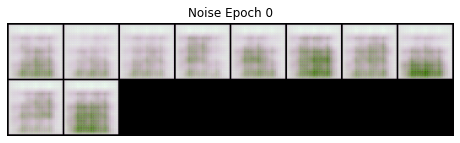

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Noise Epoch 0')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in generated_img_list[0:1]]


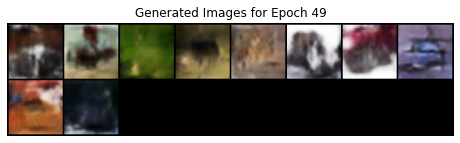

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_generated_images(epoch):
    if epoch < 0 or epoch >= len(generated_img_list):
        raise ValueError("Invalid epoch. Please provide an epoch within the range of generated images.")

    img = np.transpose(generated_img_list[epoch], (1, 2, 0))

    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images for Epoch {epoch}")
    plt.imshow(img, animated=True)
    plt.show()
visualize_generated_images(49)

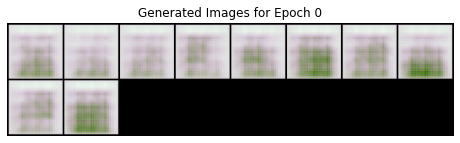

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_generated_images(epoch):
    if epoch < 0 or epoch >= len(generated_img_list):
        raise ValueError("Invalid epoch. Please provide an epoch within the range of generated images.")

    img = np.transpose(generated_img_list[epoch], (1, 2, 0))

    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images for Epoch {epoch}")
    plt.imshow(img, animated=True)
    plt.show()
visualize_generated_images(0)

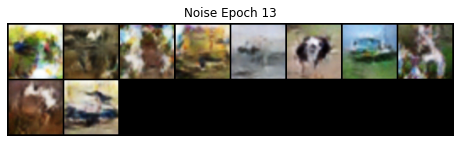

In [7]:
tr = fakeimg_list[0:50]
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Noise Epoch 13')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in tr]

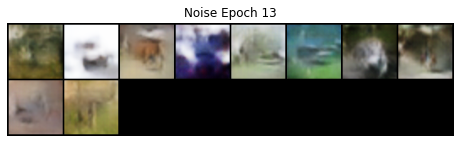

In [19]:
tr = generated_img_list[0:50]
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Noise Epoch 13')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in tr]

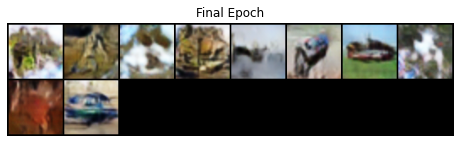

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Final Epoch')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeimg_list]

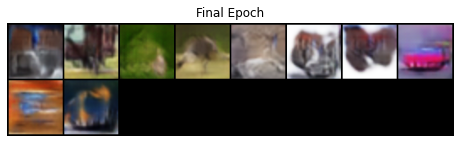

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.title('Final Epoch')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in generated_img_list]

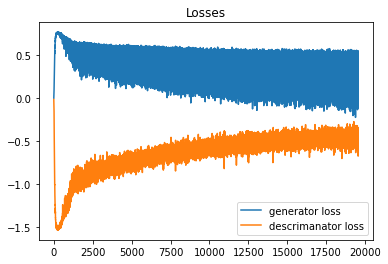

In [9]:
plt.title('Losses')
plt.plot(loss_ge,label = "generator loss")
plt.plot(loss_de,label = "descrimanator loss")
plt.legend()

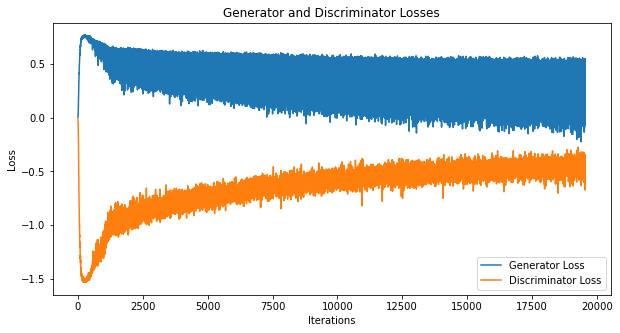

In [44]:
import matplotlib.pyplot as plt

def plot_losses(loss_generator_list, loss_discriminator_list):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Losses")
    plt.plot(loss_generator_list, label="Generator Loss")
    plt.plot(loss_discriminator_list, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Example usage
plot_losses(loss_ge, loss_de)


In [11]:
print(782*25)

19550
